In [ ]:
# from pydap.client import open_url
import os
from pydap.client import open_url
import xarray as xr
import datetime
from datetime import timedelta, date
import netCDF4 as nc
from net_cdf_functions import *
from degree_day_equations import single_sine_horizontal_cutoff
import numpy as np
%matplotlib inline

from dask.distributed import Client


client = Client(n_workers=3, threads_per_worker=2, memory_limit="2GB")
client

data_path = '/media/thom/Q/data/'

/home/thom/miniforge3/envs/fruitflypheno/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45383 instead
  warnings.warn(


In [23]:
def subset_dataset_by_coords(dataset, lat, lon):
    # Adjust dimension names according to your dataset
    subset = dataset.sel(latitude=lat, longitude=lon, method="nearest")
    return subset
# download data for eyars 2000 for january first
'''
for year in range(2020, 2021):
    for day in range(1, 2):
        fetch_and_save_data(year, 2, 10, data_path)
'''

In [73]:
prism_year_stack = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    combine="by_coords",
    drop_variables=["ppt", "tmean"],
)

la_combined = subset_dataset_by_coords(prism_year_stack, 34.05, -118.25)
vsingle_sine_horizontal_cutoff = np.vectorize(single_sine_horizontal_cutoff)

In [76]:
la_combined_DD

<xarray.Dataset> Size: 3kB
Dimensions:      (t: 210, degree_days: 210)
Coordinates:
  * t            (t) datetime64[ns] 2kB 2000-01-01 2000-01-02 ... 2020-01-10
    longitude    float64 8B -118.2
    latitude     float64 8B 34.04
  * degree_days  (degree_days) float64 2kB 0.08589 0.3629 1.17 ... 2.152 1.363
Data variables:
    *empty*
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

In [80]:
tmax = la_combined["tmax"].values
tmin = la_combined["tmin"].values
degree_days_vec = xr.apply_ufunc(
    vsingle_sine_horizontal_cutoff, tmin, tmax, kwargs={"LTT": 12, "UTT": 30}
)
degree_days_da = xr.DataArray(degree_days_vec, coords=la_combined["tmax"].coords)
la_combined_DD = la_combined.assign(degree_days=degree_days_da)
la_combined_DD = la_combined_DD.drop_vars(["tmax", "tmin"])

In [82]:
def day_cumsum_reaches_threshold(degree_days, start_day, threshold):
    cumsum = degree_days[start_day:].cumsum()
    print(cumsum)
    days_to_threshold = xr.where(cumsum >= threshold, cumsum.t, np.nan).min()
    return days_to_threshold.item() if not np.isnan(days_to_threshold) else None

In [89]:
# la_combined_DD["degree_days"].isel(t=slice(4, None))
# repeat but use .sel for date 01-03-2001
la_combined_DD["degree_days"].sel(t=slice("2001-01-03", None))

<xarray.DataArray 'degree_days' (t: 198)> Size: 2kB
array([5.63797148, 6.22099598, 7.02952148, 3.6443808 , 3.61667849,
       3.468531  , 0.40655286, 1.95016525, 1.97389835, 2.79189264,
       2.171222  , 1.86328544, 2.19799277, 3.70260733, 4.07687724,
       5.47427685, 5.33671278, 2.35924624, 1.27781182, 3.43772778,
       5.59847652, 7.77200031, 7.13383126, 7.39651489, 8.68949986,
       8.95149946, 3.84599972, 2.4483527 , 1.89845765, 1.51208192,
       0.        , 0.55611771, 1.16707261, 2.3484105 , 2.50692419,
       2.96398981, 4.0497027 , 3.83934817, 0.54670389, 0.32080372,
       0.26785609, 0.26672477, 0.        , 0.47948877, 0.69592518,
       0.22470539, 1.90499973, 3.25750017, 0.96405759, 1.41129234,
       1.30939965, 1.49961464, 5.13866437, 8.40899992, 8.43561704,
       4.19697013, 3.24590621, 5.40903696, 1.55584618, 2.77630522,
       4.67816261, 4.28827624, 1.66870592, 1.64873488, 2.71567558,
       4.9641001 , 8.69714996, 8.1804388 , 4.22066092, 4.46527299,
       4.92596837, 2.92867167, 1.2325855 , 1.3755002 , 0.19875555,
       1.40374328, 0.95882802, 0.88088969, 2.67187846, 2.80608896,
       0.        , 1.5029283 , 1.93422253, 0.96841698, 1.8404643 ,
       3.37018534, 2.75908695, 4.18456047, 2.88700227, 3.78763006,
       6.22368035, 6.56169895, 5.68414718, 5.61682923, 5.01930807,
       4.44012606, 6.0236959 , 5.97620772, 0.23091514, 0.68412318,
       0.        , 0.36325407, 1.92591759, 2.59386163, 3.69652667,
       1.65278607, 0.80569133, 0.67351617, 4.70053091, 6.96659669,
       6.39720594, 7.04532749, 9.23498348, 7.80464572, 4.45683158,
       1.5869401 , 3.32692184, 4.62500277, 0.6537314 , 1.04545771,
       2.05552518, 3.1189088 , 2.37163407, 2.15046027, 0.46225937,
       2.70013458, 3.7358343 , 3.07844717, 3.79399091, 3.8970533 ,
       6.61749568, 4.16245307, 3.2958985 , 5.03059738, 5.61042605,
       3.32676438, 2.93937989, 1.96324499, 0.24325697, 0.48256265,
       0.82504115, 1.18993431, 2.96787966, 6.9201999 , 9.15199995,
       7.96237868, 5.10032934, 4.92700052, 1.9853728 , 1.84692295,
       2.21608969, 1.45629361, 4.27199984, 0.51001406, 0.23043962,
       0.6353161 , 1.21061826, 0.8805617 , 0.63911102, 0.72002364,
       0.48976759, 0.97268154, 1.53823623, 2.36059136, 2.58243445,
       3.81444449, 6.23821158, 1.87021582, 3.31394489, 3.90928946,
       6.49989498, 5.68674808, 5.84142775, 5.29300022, 4.86049986,
       6.43249941, 5.22100019, 1.05014381, 1.72509721, 1.11203362,
       1.35713235, 2.49269874, 2.25703445, 0.662182  , 1.24944327,
       1.46261754, 4.15780227, 2.94521198, 4.52111327, 3.18187106,
       3.27108588, 4.18094598, 3.70246982, 3.6522215 , 5.77965496,
       6.26031394, 2.15228087, 1.36349951])
Coordinates:
  * t          (t) datetime64[ns] 2kB 2001-01-03 2001-01-04 ... 2020-01-10
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04

In [83]:
threshold = 10

# Compute the day when cumulative sum reaches the threshold starting from day 1
start_day_1 = 0  # Index 0 corresponds to day 1
day_reach_threshold_from_start = day_cumsum_reaches_threshold(
    la_combined_DD, start_day_1, threshold
)
"""
# Compute the day when cumulative sum reaches the threshold starting from day 10
start_day_10 = 9  # Index 9 corresponds to day 10
day_reach_threshold_from_day_10 = day_cumsum_reaches_threshold(
    la_combined_DD, start_day_10, threshold
)
"""

KeyError: "No variable named slice(0, None, None). Variables on the dataset include ['t', 'longitude', 'latitude', 'degree_days']"

In [49]:
tmax[42]

11.687000274658203

In [48]:
tmin[42]

7.039000034332275

In [3]:
import xarray as xr
import numpy as np


def calculate_degree_days(tmax, tmin, base_temp=10):
    """
    Calculate degree days from tmax and tmin.
    Degree days = (tmax + tmin) / 2 - base_temp
    """
    mean_temp = (tmax + tmin) / 2
    degree_days = mean_temp - base_temp
    return degree_days


def process_dataset(dataset):
    """
    Apply degree days calculation and drop tmax and tmin variables.
    """
    # Directly access tmax and tmin
    tmax = dataset["tmax"]
    tmin = dataset["tmin"]

    # Print dimensions and coordinates for debugging
    print("Dimensions of tmax:", tmax.dims)
    print("Dimensions of tmin:", tmin.dims)
    print("Coordinates of dataset:", dataset.coords)

    # Calculate degree days using apply_ufunc
    degree_days = xr.apply_ufunc(
        single_sine_horizontal_cutoff,
        tmax,
        tmin,
        input_core_dims=[["t"], ["t"]],
        output_core_dims=[["t"]],  # No core dimensions for the output
        vectorize=True,
        dask="allowed",  # Ensure compatibility with dask
        output_dtypes=[float],  # Specify output data type
    )

    # Print dimensions of degree_days for debugging
    print("Dimensions of degree_days:", degree_days.dims)

    # Create a new DataArray with the degree days
    degree_days_da = xr.DataArray(
        degree_days,
        dims=["time"],  # Use 'time' dimension for the DataArray
        coords={
            "time": dataset["time"].values
        },  # Use 'time' coordinate from the original dataset
        name="degree_days",
    )

    # Add degree days to the dataset and drop tmax and tmin
    dataset = dataset.assign(degree_days=degree_days_da)
    dataset = dataset.drop_vars(["tmax", "tmin"])

    return dataset


# Example usage
base_dir = data_path
start_year = 2000
end_year = 2020
start_day = 1
end_day = 10

combined_dataset = load_and_concatenate_datasets(
    start_year, end_year, start_day, end_day, base_dir
)

# Process the dataset
processed_dataset = process_dataset(combined_dataset)

# Persist or compute if needed
processed_dataset = processed_dataset.persist()

# Subset dataset by coordinates
la_combined = subset_dataset_by_coords(processed_dataset, 34.05, -118.25)

# Print dataset information
print(la_combined)
print(la_combined.dims)
print(la_combined.variables)

Dimensions of tmax: ('t', 'latitude', 'longitude')
Dimensions of tmin: ('t', 'latitude', 'longitude')
Coordinates of dataset: Coordinates:
  * t          (t) datetime64[ns] 2kB 2000-01-01 2000-01-02 ... 2020-01-10
  * longitude  (longitude) float64 11kB -125.0 -125.0 -124.9 ... -66.54 -66.5
  * latitude   (latitude) float64 5kB 49.92 49.88 49.83 ... 24.17 24.12 24.08


ValueError: The truth value of a Array is ambiguous. Use a.any() or a.all().

In [48]:
import xarray as xr
import numpy as np
from dask import array as da


def process_dataset(dataset):
    """
    Apply degree days calculation and drop tmax and tmin variables.
    """
    # Ensure tmax and tmin are dask arrays
    tmax = dataset["tmax"]
    tmin = dataset["tmin"]

    # Calculate degree days using map_blocks
    degree_days = da.map_blocks(
        lambda tmax, tmin: single_sine_horizontal_cutoff(tmax, tmin),
        tmax,
        tmin,
        dtype=float,
    )

    # Create a new DataArray with the degree days
    degree_days_da = xr.DataArray(degree_days, dims=dataset.dims, coords=dataset.coords)

    # Add degree days to the dataset and drop tmax and tmin
    dataset = dataset.assign(degree_days=degree_days_da)
    dataset = dataset.drop_vars(["tmax", "tmin"])

    return dataset


# Process the dataset
processed_la = process_dataset(la_combined)

processed_la = processed_la.compute()
# Subset dataset by coordinates

# Print dataset information

ValueError: different number of dimensions on data and dims: 0 vs 2

In [46]:
import xarray as xr
import numpy as np
from dask import array as da


def calculate_degree_days(tmax, tmin, base_temp=10):
    """
    Calculate degree days from tmax and tmin.
    Degree days = (tmax + tmin) / 2 - base_temp
    """
    mean_temp = (tmax + tmin) / 2
    degree_days = mean_temp - base_temp
    return degree_days


def process_dataset(dataset):
    """
    Apply degree days calculation and drop tmax and tmin variables.
    """
    # Directly access tmax and tmin
    tmax = dataset["tmax"]
    tmin = dataset["tmin"]

    # Calculate degree days
    degree_days = xr.apply_ufunc(
        calculate_degree_days,
        tmax,
        tmin,
        input_core_dims=[["time"], ["time"]],
        output_core_dims=[["time"]],
        vectorize=True,
        dask="allowed",  # Ensure compatibility with dask
    )

    # Create a new DataArray with the degree days
    degree_days_da = xr.DataArray(
        degree_days,
        dims=dataset.dims,  # Use dimensions from the original dataset
        coords=dataset.coords,  # Use coordinates from the original dataset
        name="degree_days",
    )

    # Add degree days to the dataset and drop tmax and tmin
    dataset = dataset.assign(degree_days=degree_days_da)
    dataset = dataset.drop_vars(["tmax", "tmin"])

    return dataset


processed_dataset = process_dataset(la_combined)

# Persist or compute if needed
processed_dataset = processed_dataset.persist()

ValueError: tuple.index(x): x not in tuple

In [26]:
print(la_combined)

<xarray.Dataset> Size: 5kB
Dimensions:    (t: 210)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2000-01-01 2000-01-02 ... 2020-01-10
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
Data variables:
    tmin       (t) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    tmax       (t) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t


In [ ]:
import dask.array as da
import numpy as np

# Define the shape of the array
lat, lon = 10, 10
days_per_year = 365
years = 2
variables = 2  # tmean and tmax
total_days = days_per_year * years

# Create larger random data for tmean and tmax to ensure cumulative sum can reach 50
tmean_data = np.random.rand(total_days, lat, lon) * 10
tmax_data = np.random.rand(total_days, lat, lon) * 10

# Stack the data along a new axis to create a single array
data = np.stack([tmean_data, tmax_data], axis=0)  # Shape will be (variables, total_days, lat, lon)

# Convert the numpy array to a dask array
dask_array = da.from_array(data, chunks=(variables, days_per_year//4, lat//2, lon//2))  # Adjust chunks as needed

# Add one to every day for each variable
dask_array_plus_one = dask_array + 1

# Split the array into separate years
dask_array_years = [dask_array_plus_one[:, i*days_per_year:(i+1)*days_per_year, :, :] for i in range(years)]

# Calculate the cumulative sum along the time (days) axis for each year
cumsum_arrays = [da.cumsum(year, axis=1) for year in dask_array_years]

# Function to find the first day when the cumulative sum is >= 50
def find_day_where_cumsum_is_50(cumsum_slice):
    condition_met = (cumsum_slice >= 50)
    if condition_met.any():
        return condition_met.argmax(axis=0)
    else:
        # Return days_per_year if the condition is never met
        return days_per_year * np.ones_like(cumsum_slice[0], dtype=int)

# Apply the function along the days axis (axis=1) for each year's cumulative sum
days_reaching_50_each_year = [da.apply_along_axis(find_day_where_cumsum_is_50, 1, cumsum) for cumsum in cumsum_arrays]

# Stack the results to get an array of shape (years, variables, lat, lon)
days_reaching_50_result = da.stack(days_reaching_50_each_year)

# Compute the result
days_reaching_50_result_computed = days_reaching_50_result.compute()

# Verification: Check some values from the result
print("Shape of days_reaching_50_result_computed:", days_reaching_50_result_computed.shape)
print("Days reaching 50 for tmean (variable 0) in year 1:")
print(days_reaching_50_result_computed[0, 0])
print("\nDays reaching 50 for tmax (variable 1) in year 1:")
print(days_reaching_50_result_computed[0, 1])
print("\nDays reaching 50 for tmean (variable 0) in year 2:")
print(days_reaching_50_result_computed[1, 0])
print("\nDays reaching 50 for tmax (variable 1) in year 2:")
print(days_reaching_50_result_computed[1, 1])


In [ ]:
ds = nc.Dataset("data/test/derived/PRISM_mean_2000-2020.nc", "r", format="NETCDF4")

In [13]:
# take mean of netcdf "data/test/PRISM/2020/PRISM_combo_20200101.nc"

# Open the NetCDF file
dataset = nc.Dataset("data/test/PRISM/2020/PRISM_combo_20200101.nc", "r")

In [34]:
dataset = nc.Dataset("data/test/PRISM/2020/PRISM_combo_20200101.nc", "r")

In [49]:
import concurrent.futures
import time


def compute(x):
    time.sleep(2)  # Simulate a time-consuming computation
    return x * x


def main():
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit tasks to the executor
        futures = [executor.submit(compute, i) for i in range(5)]

        for future in concurrent.futures.as_completed(futures):
            result = future.result()  # This blocks until the result is available
            print(f"Result: {result}")


if __name__ == "__main__":
    main()

Result: 0
Result: 1
Result: 4
Result: 9
Result: 16


In [46]:
import netCDF4 as nc
import numpy as np


def extract_values_from_ncdf(file_path, coord, variables):
    """
    Extract values at a given coordinate from specified variables in a NetCDF file.

    Parameters:
    - file_path (str): Path to the NetCDF file.
    - coord (tuple): Tuple of (latitude, longitude) for the target coordinate.
    - variables (list): List of variable names to extract.

    Returns:
    - dict: A dictionary with variable names as keys and extracted values as values.
    """
    target_lat, target_lon = coord

    with nc.Dataset(file_path, "r") as dataset:
        # Get the latitude and longitude variables
        lat = dataset.variables["latitude"][:]
        lon = dataset.variables["longitude"][:]

        # Find the nearest indices for the given coordinates
        lat_idx = np.abs(lat - target_lat).argmin()
        lon_idx = np.abs(lon - target_lon).argmin()

        # Extract values for each variable
        values = tuple(
            dataset.variables[var][0, lat_idx, lon_idx].data.item() for var in variables
        )
        # note to potentially clip NCDF values
    return values


# Example usage:
file_path = "data/test/PRISM/2020/PRISM_combo_20200101.nc"
coord = (34.05, -118.25)
variables = ["tmin", "tmax"]
values = extract_values_from_ncdf(file_path, coord, variables)
print(values)

(9.517000198364258, 22.58799934387207)


In [23]:
import concurrent.futures
import netCDF4 as nc
import numpy as np


def extract_values(file_path, coord, variables):
    target_lat, target_lon = coord

    with nc.Dataset(file_path, "r") as dataset:
        lat = dataset.variables["latitude"][:]
        lon = dataset.variables["longitude"][:]

        lat_idx = np.abs(lat - target_lat).argmin()
        lon_idx = np.abs(lon - target_lon).argmin()

        values = tuple(
            dataset.variables[var][0, lat_idx, lon_idx].data.item() for var in variables
        )

    return values


def process_day(file_path, coord, variables, LTT, UTT):
    tmin, tmax = extract_values(file_path, coord, variables)
    return single_sine_horizontal_cutoff(tmin, tmax, LTT, UTT)


def process_days_concurrently(file_path, coord, variables, LTT, UTT, dates):
    results = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for date in dates:
            # Submit the process_day task to the executor
            future = executor.submit(process_day, file_path, coord, variables, LTT, UTT)
            futures.append(future)

        # Collect results as they complete
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())

    return results


# Example usage
file_path = "your_file.nc"
coord = (34.05, -118.25)
variables = ["tmin", "tmax"]
LTT = 10
UTT = 20
dates = ["2024-07-01", "2024-07-02", "2024-07-03"]

results = process_days_concurrently(file_path, coord, variables, LTT, UTT, dates)
print(results)

(381, 162)

In [50]:
import netCDF4 as nc
import numpy as np


def get_file_path_PRISM(year, month, day, base_dir):
    
    
    file_path = f"{base_dir}/{year}/PRISM_combo_{year}{month}{day}.nc"
    return file_path


def extract_values(file_path, coord, variables):
    target_lat, target_lon = coord

    with nc.Dataset(file_path, "r") as dataset:
        lat = dataset.variables["latitude"][:]
        lon = dataset.variables["longitude"][:]

        lat_idx = np.abs(lat - target_lat).argmin()
        lon_idx = np.abs(lon - target_lon).argmin()

        values = tuple(
            dataset.variables[var][0, lat_idx, lon_idx].data.item() for var in variables
        )

    return values


def process_days(start_date, coord, variables, LTT, UTT, target_GDD_value):
    accumulated_GDD_result = 0
    
    data_date = start_date
    while accumulated_GDD_result < target_GDD_value:
        date_path = get_file_path_PRISM(data_date.year, data_date.month, data_date.day, "data/test/PRISM/")

        tmin, tmax = extract_values(file_path, coord, variables)
        daily_result = single_sine_horizontal_cutoff(tmin, tmax, LTT, UTT)
        accumulated_GDD_result += daily_result
        

        
    return accumulated_result, total_days_processed

In [51]:
get_file_paths(2020, "01", "01", "data/test/PRISM")

['data/test/PRISM/2020/PRISM_combo_20200101.nc',
 'data/test/PRISM/2020/PRISM_combo_20200101.nc',
 'data/test/PRISM/2020/PRISM_combo_20200101.nc']

/home/thom/miniforge3/envs/fruitflypheno/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/thom/miniforge3/envs/fruitflypheno/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/thom/miniforge3/envs/fruitflypheno/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/thom/miniforge3/envs/fruitflypheno/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downl

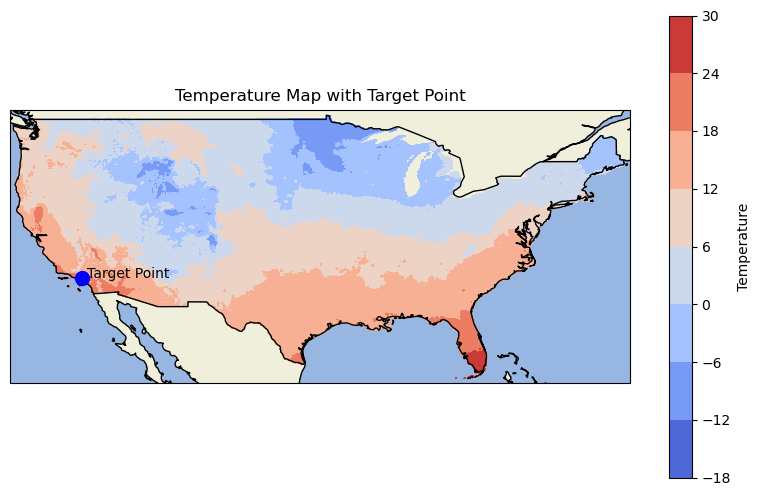

In [30]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Open the NetCDF file

# Get the latitude and longitude variables
lat = dataset.variables["latitude"][:]
lon = dataset.variables["longitude"][:]

# Get the data variable (e.g., temperature)
data = dataset.variables["tmax"][:]

# Your target coordinate
target_lat = 34.05  # example latitude
target_lon = -118.25  # example longitude

# Find the nearest indices for the given coordinates
lat_idx = np.abs(lat - target_lat).argmin()
lon_idx = np.abs(lon - target_lon).argmin()

# Plot the data
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Plot the data as a contourf plot
plt.contourf(lon, lat, data[0, :, :], transform=ccrs.PlateCarree(), cmap="coolwarm")
plt.colorbar(label="Temperature")

# Plot the target point
plt.plot(target_lon, target_lat, "bo", markersize=10, transform=ccrs.PlateCarree())
plt.text(target_lon + 0.5, target_lat, "Target Point", transform=ccrs.PlateCarree())

# Add title and labels
plt.title("Temperature Map with Target Point")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close the dataset
dataset.close()

In [62]:
import dask.array as da
import numpy as np

# Define the shape of the array
lat, lon = 10, 10
days_per_year = 365
years = 2
variables = 2  # tmean and tmax
total_days = days_per_year * years

# Create larger random data for tmean and tmax to ensure cumulative sum can reach 50
tmean_data = np.random.rand(total_days, lat, lon) * 10
tmax_data = np.random.rand(total_days, lat, lon) * 10

# Stack the data along a new axis to create a single array
data = np.stack(
    [tmean_data, tmax_data], axis=0
)  # Shape will be (variables, total_days, lat, lon)

# Convert the numpy array to a dask array
dask_array = da.from_array(
    data, chunks=(variables, days_per_year // 4, lat // 2, lon // 2)
)  # Adjust chunks as needed

# Add one to every day for each variable
dask_array_plus_one = dask_array + 1

# Split the array into separate years
dask_array_years = [
    dask_array_plus_one[:, i * days_per_year : (i + 1) * days_per_year, :, :]
    for i in range(years)
]

# Calculate the cumulative sum along the time (days) axis for each year
cumsum_arrays = [da.cumsum(year, axis=1) for year in dask_array_years]


# Function to find the first day when the cumulative sum is >= 50
def find_day_where_cumsum_is_50(cumsum_slice):
    condition_met = cumsum_slice >= 50
    if condition_met.any():
        return condition_met.argmax(axis=0)
    else:
        # Return days_per_year if the condition is never met
        return days_per_year * np.ones_like(cumsum_slice[0], dtype=int)


# Apply the function along the days axis (axis=1) for each year's cumulative sum
days_reaching_50_each_year = [
    da.apply_along_axis(find_day_where_cumsum_is_50, 1, cumsum)
    for cumsum in cumsum_arrays
]

# Stack the results to get an array of shape (years, variables, lat, lon)
days_reaching_50_result = da.stack(days_reaching_50_each_year)

# Compute the result
days_reaching_50_result_computed = days_reaching_50_result.compute()

# Verification: Check some values from the result
print(
    "Shape of days_reaching_50_result_computed:", days_reaching_50_result_computed.shape
)
print("Days reaching 50 for tmean (variable 0) in year 1:")
print(days_reaching_50_result_computed[0, 0])
print("\nDays reaching 50 for tmax (variable 1) in year 1:")
print(days_reaching_50_result_computed[0, 1])
print("\nDays reaching 50 for tmean (variable 0) in year 2:")
print(days_reaching_50_result_computed[1, 0])
print("\nDays reaching 50 for tmax (variable 1) in year 2:")
print(days_reaching_50_result_computed[1, 1])

Shape of days_reaching_50_result_computed: (2, 2, 10, 10)
Days reaching 50 for tmean (variable 0) in year 1:
[[ 7 10  9  9  8  8  7  8  9  9]
 [ 7  5  6 10  6  9  6  8  8  7]
 [ 8  9  6  7  8  9  9  5  7  6]
 [ 9  7  7 10 12  6 10  6 11 10]
 [ 6  9  8  9  7  6  8  7  7  8]
 [ 7  7  6  8  7  7  8  8 11  8]
 [ 9  7 10  7  8  8  6  7  8  5]
 [ 6  8  7  8  9  9  9  8  6  8]
 [ 7  8  7  7  6 10  8  7  5  8]
 [ 5 10  6  8  6  6  7  7  9  9]]

Days reaching 50 for tmax (variable 1) in year 1:
[[ 8  7 10  7  9  7  9  7  7  9]
 [ 7  8  6  7  6  8 10 10 11  8]
 [ 7  8  8 10  7  9  9  9  7  8]
 [10  6  8  6  6  8  8  6  8  8]
 [ 7  9  8  8  9  7  8  8  8  8]
 [ 7  9  7  7 11  8  6  7  9  6]
 [ 8  8  5  7 11  9  8 10  9  6]
 [ 8  8  8  9  7  6  8  6  7  8]
 [ 8  8  7  9  5  8  9  9  6  8]
 [10  7  9  7  9  6 10  8  8  9]]

Days reaching 50 for tmean (variable 0) in year 2:
[[ 8  8  7  7  9  9  8  8  7  8]
 [ 9  8 10  9  8 11  8  9  9  6]
 [ 8  8  8  7  7  9  7  7 10  7]
 [ 8 11 12  9 10  7  6  8 1

In [54]:
import dask.array as da
import numpy as np

# Define the shape of the array
lat, lon = 10, 10
days_per_year = 365
years = 2
variables = 2  # tmean and tmax
total_days = days_per_year * years

# Create larger random data for tmean and tmax to ensure cumulative sum can reach 50
tmean_data = np.random.rand(total_days, lat, lon) * 10
tmax_data = np.random.rand(total_days, lat, lon) * 10

# Stack the data along a new axis to create a single array
data = np.stack(
    [tmean_data, tmax_data], axis=0
)  # Shape will be (variables, total_days, lat, lon)

# Convert the numpy array to a dask array
dask_array = da.from_array(
    data, chunks=(variables, days_per_year // 4, lat // 2, lon // 2)
)  # Adjust chunks as needed

# Add one to every day for each variable
dask_array_plus_one = dask_array + 1

# Split the array into separate years
dask_array_years = [
    dask_array_plus_one[:, i * days_per_year : (i + 1) * days_per_year, :, :]
    for i in range(years)
]

# Calculate the cumulative sum along the time (days) axis for each year
cumsum_arrays = [da.cumsum(year, axis=1) for year in dask_array_years]


# Function to find the first day when the cumulative sum is >= 50
def find_day_where_cumsum_is_50(cumsum_slice):
    condition_met = cumsum_slice >= 50
    if condition_met.any():
        return condition_met.argmax(axis=0)
    else:
        # Return days_per_year if the condition is never met
        return days_per_year * np.ones_like(cumsum_slice[0], dtype=int)


# Apply the function along the days axis (axis=1) for each year's cumulative sum
days_reaching_50_each_year = [
    da.apply_along_axis(find_day_where_cumsum_is_50, 1, cumsum)
    for cumsum in cumsum_arrays
]

# Stack the results to get an array of shape (years, variables, lat, lon)
days_reaching_50_result = da.stack(days_reaching_50_each_year)

# Compute the result
days_reaching_50_result_computed = days_reaching_50_result.compute()

# Verification: Check some values from the result
print(
    "Shape of days_reaching_50_result_computed:", days_reaching_50_result_computed.shape
)
print("Days reaching 50 for tmean (variable 0) in year 1:")
print(days_reaching_50_result_computed[0, 0])
print("\nDays reaching 50 for tmax (variable 1) in year 1:")
print(days_reaching_50_result_computed[0, 1])
print("\nDays reaching 50 for tmean (variable 0) in year 2:")
print(days_reaching_50_result_computed[1, 0])
print("\nDays reaching 50 for tmax (variable 1) in year 2:")
print(days_reaching_50_result_computed[1, 1])

Shape of days_reaching_50_result_computed: (2, 2, 10, 10)
Days reaching 50 for tmean (variable 0) in year 1:
[[ 7 10  7 12  5  7 11 10  9  8]
 [ 8  9  6 11  6  8  9  8  6  7]
 [10  5  7  8  8  8  7  9  8  9]
 [ 9 10  8  7  7  9  8  5  8  5]
 [ 8  7  8  8  7 10  5  7  9  8]
 [ 5  7  6  9 10  7  7  6  9  8]
 [ 6  7  9  8 11  9  8  7  7  9]
 [ 8  6 10  9  8  6  9  7  8  9]
 [ 7  9  9  7  7  9  7  7  7  7]
 [ 8 11  8  8  8  8  8 14  6  6]]

Days reaching 50 for tmax (variable 1) in year 1:
[[ 6  7 10  7  9  9  9  8  8  8]
 [ 8  7  8  6  7  7  7  9  7 10]
 [ 8 10  8  7  8  7  7  9  9  8]
 [ 6  9  7  9 10  5  7  9  7  8]
 [ 6  7  9  7  9  7 10  9  7  7]
 [ 7  8  7  8  7  5  9  8  9 10]
 [ 8 10 11  7  7  7  6 10  7 13]
 [ 8  7  8  7  8  8  9  9  7  9]
 [ 8  7  7  8  8  9  7 11  8  7]
 [ 9  6 10  9  6  8 11  7  8  8]]

Days reaching 50 for tmean (variable 0) in year 2:
[[ 9  8  7  8 11  7  9  8  8  6]
 [ 7  6 10 10 13 10  7  5  7 10]
 [ 9  8  9  8  8 12  6  7  9  8]
 [ 7  7  7  8 12 10  9  8  

In [58]:
days_reaching_50_result.visualize()

RuntimeError: No visualization engine detected, please install graphviz or ipycytoscape

In [ ]:
samp

('https://tds.climate.ncsu.edu/thredds/dodsC/prism/daily/combo/2020/PRISM_combo_20201231.nc',
 <DatasetType with children 't', 'ppt', 'tmean', 'tmin', 'tmax', 'longitude', 'latitude'>)